#신경망 모델 훈련
###IT융합자율학부 201814076 권혁준

##손실 곡선

##인공 신경망의 과대적합과 과소적합
- 신경망 모델은 경사 하강법으로 훈련되기 때문에 모델이 과대적합 되거나 과소적합 될 가능성이 있음
- 훈련 세트에 대한 손실과 검증 세트에 대한 손실을 고려하여 해결
  - 모델의 최적화 대상이 손실이며, 정확도 향상과 손실 감소가 정확하게 비례하지 않기 때문에 손실을 기준으로 분석해야 함

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


In [2]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [3]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0) # verbose 0도 넣어보고 1도 넣어보고 2도 넣어보기

In [5]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


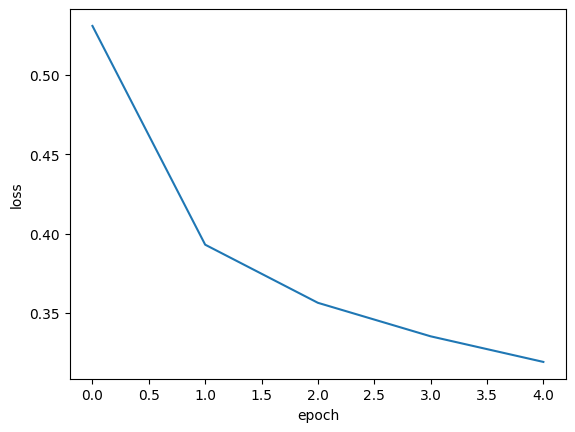

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

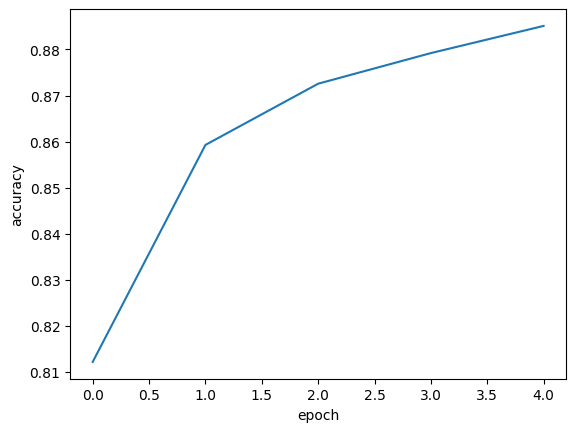

In [7]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

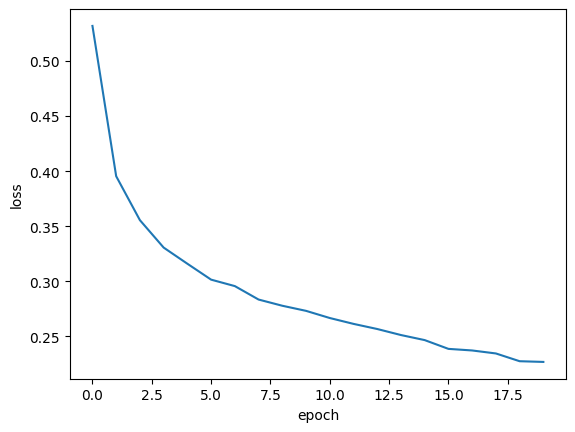

In [8]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

##검증 손실
- 검증 손실이 상승하는 시점을 가능한 뒤로 늦출수록 검증 세트에 대한 손실을 줄이고, 검증 세트에 대한 정확도를 증가시킬 수 있음

In [9]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

In [10]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


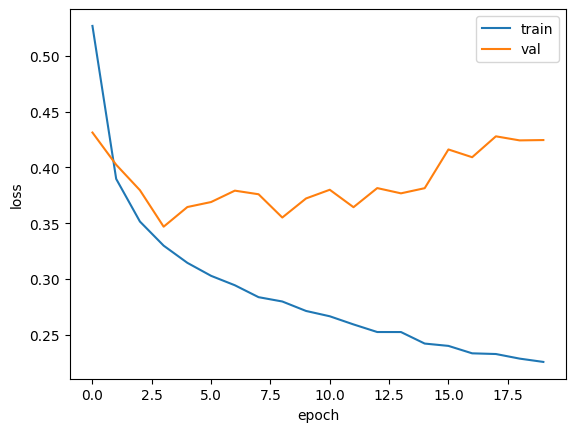

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

##과대적합 완화
- 옵티마이저 설정 변경
  - 데이터셋에 잘 맞는 옵티마이저 사용으로 과대적합을 일부 완화할 수 있음

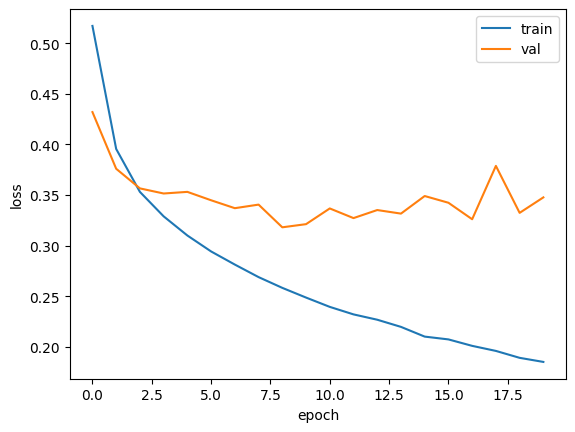

In [12]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

##드롭아웃 (dropout)
- 제프리 힌튼(Geoffrey Hinton)이 고안
- 신경망 훈련 과정에서 은닉층에 있는 일부 뉴런을 임의로 꺼서(출력을 0으로 만들어) 과대적합을 막는 방법
  - 뉴런이 드롭아웃되면 특정 뉴런에 의존하지 않고 모든 입력에 대해 주의를 기울임
- 신경망 훈련 시에만 적용하며, 평가나 예측을 할 때는 적용하지 않음

In [13]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


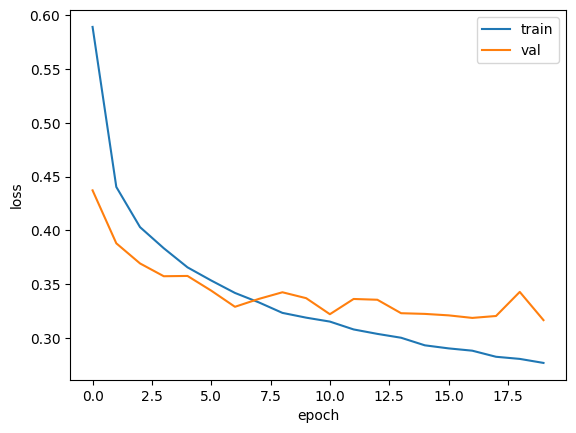

In [14]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

##모델 저장
- 최적의 모델을 재사용하기 위해선 모델 저장이 필요
- save_weight()
  - 훈련된 모델 파라미터를 저장

##모델의 복원
- 새로운 모델을 만들고 파일에서 훈련된 모델 파라미터 불러오기
- 저장돈 모델로부터 모델 구조와 모델 파라미터를 한 번에 복원하기

In [15]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0,
                    validation_data=(val_scaled, val_target))

In [16]:
model.save_weights('model-weights.h5')

In [17]:
model.save('model-whole.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
!ls -al *.h5

-rw-r--r-- 1 root root 333320 Nov 12 12:43 model-weights.h5
-rw-r--r-- 1 root root 981176 Nov 12 12:43 model-whole.h5


In [19]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

In [20]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

375/375 [==============================] - 1s 2ms/step
0.879


In [21]:
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3344 - accuracy: 0.8790


[0.3343747556209564, 0.8790000081062317]

##콜백(callback)
- 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체

In [22]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5',
                                                save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

In [23]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3168 - accuracy: 0.8878


[0.3167915940284729, 0.8877500295639038]

In [24]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [25]:
print(early_stopping_cb.stopped_epoch)

10


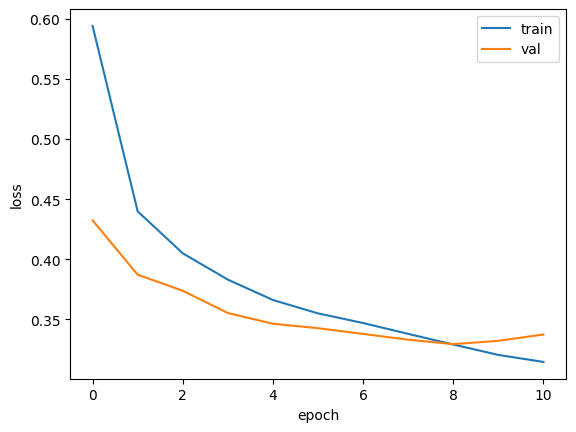

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [27]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3294 - accuracy: 0.8797


[0.3293709456920624, 0.8796666860580444]